In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import logit
from scipy.stats import mannwhitneyu
import warnings

warnings.filterwarnings('ignore')

# 1. Load DataFrames
patients = pd.read_csv("C:\\Users\\ItamarMelnik\\Desktop\\ML in medicine\\mimic-iii-clinical-database-demo-1.4\\PATIENTS.csv")
admissions = pd.read_csv("C:\\Users\\ItamarMelnik\\Desktop\\ML in medicine\\mimic-iii-clinical-database-demo-1.4\\ADMISSIONS.csv")
icustays = pd.read_csv("C:\\Users\\ItamarMelnik\\Desktop\\ML in medicine\\mimic-iii-clinical-database-demo-1.4\\ICUSTAYS.csv")
labevents = pd.read_csv("C:\\Users\\ItamarMelnik\\Desktop\\ML in medicine\\mimic-iii-clinical-database-demo-1.4\\LABEVENTS.csv")
diagnoses = pd.read_csv("C:\\Users\\ItamarMelnik\\Desktop\\ML in medicine\\mimic-iii-clinical-database-demo-1.4\\DIAGNOSES_ICD.csv")

# 2. Merge patients with icustays for demographic information
demo_data = icustays.merge(patients, on='subject_id', how='left')

# 3. Add information from admissions DataFrame
demo_data = demo_data.merge(admissions[['subject_id', 'hadm_id', 'ethnicity']], on=['subject_id', 'hadm_id'], how='left')

# 4. Convert dates to datetime format
demo_data['intime'] = pd.to_datetime(demo_data['intime'])
demo_data['outtime'] = pd.to_datetime(demo_data['outtime'])
demo_data['dob'] = pd.to_datetime(demo_data['dob'])
demo_data['dod'] = pd.to_datetime(demo_data['dod'])

# 5. Calculate age
demo_data['age'] = demo_data['intime'].dt.year - demo_data['dob'].dt.year

# 6. Identify death during ICU stay
demo_data['death_during_icu'] = (demo_data['dod'] <= demo_data['outtime']).astype(int)

# 7. Filter for creatinine lab events
creatinine_labs = labevents[labevents['itemid'] == 50912].copy()
creatinine_labs['charttime'] = pd.to_datetime(creatinine_labs['charttime'])

# 8. Merge creatinine lab events with icustays
creatinine_merged = creatinine_labs.merge(
    icustays[['subject_id', 'hadm_id', 'icustay_id', 'intime']],
    on=['subject_id', 'hadm_id'],
    how='inner'
)

# 9. Filter creatinine lab events after ICU admission
creatinine_icu = creatinine_merged[creatinine_merged['charttime'] >= creatinine_merged['intime']]

# 10. Filter valid creatinine lab events (non-null values)
creatinine_valid = creatinine_icu[~creatinine_icu['valuenum'].isna()]

# 11. Select the first valid creatinine lab event for each ICU stay
creatinine_first_valid = creatinine_valid.sort_values('charttime').groupby(['subject_id', 'hadm_id', 'icustay_id']).first().reset_index()

# 12. Add creatinine value to the merged DataFrame
demo_data = demo_data.merge(
    creatinine_first_valid[['subject_id', 'hadm_id', 'icustay_id', 'valuenum']],
    on=['subject_id', 'hadm_id', 'icustay_id'],
    how='left'
)
demo_data = demo_data.rename(columns={'valuenum': 'creatinine'})

# 13. Identify diabetic patients (ICD-9 codes starting with 250)
diabetes_dx = diagnoses[diagnoses['icd9_code'].astype(str).str.startswith('250')]
has_diabetes = diabetes_dx.drop_duplicates('subject_id')[['subject_id']].assign(has_diabetes=1)
demo_data = demo_data.merge(has_diabetes[['subject_id', 'has_diabetes']], on='subject_id', how='left')
demo_data['has_diabetes'] = demo_data['has_diabetes'].fillna(0).astype(int)

# 14. Select final columns
final_columns = ['subject_id', 'icustay_id', 'gender', 'age', 'ethnicity',
                 'creatinine', 'has_diabetes', 'death_during_icu']

df = demo_data[final_columns].copy()

df.head()

,subject_id,icustay_id,gender,age,ethnicity,creatinine,has_diabetes,death_during_icu
0,10006,206504,F,70,BLACK/AFRICAN AMERICAN,3.5,1,0
1,10011,232110,F,36,UNKNOWN/NOT SPECIFIED,0.7,0,1
2,10013,264446,F,87,UNKNOWN/NOT SPECIFIED,1.7,0,1
3,10017,204881,F,74,WHITE,0.3,1,0
4,10019,228977,M,49,WHITE,6.4,0,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        136 non-null    int64  
 1   icustay_id        136 non-null    int64  
 2   gender            136 non-null    object 
 3   age               136 non-null    int32  
 4   ethnicity         136 non-null    object 
 5   creatinine        134 non-null    float64
 6   has_diabetes      136 non-null    int32  
 7   death_during_icu  136 non-null    int32  
dtypes: float64(1), int32(3), int64(2), object(2)
memory usage: 7.0+ KB


In [3]:
df.describe()

,subject_id,icustay_id,age,creatinine,has_diabetes,death_during_icu
count,136.000000,136.000000,136.000000,134.000000,136.000000,136.000000
mean,28263.485294,250980.470588,84.705882,1.414179,0.382353,0.235294
std,16008.281510,28455.125832,59.532390,1.321207,0.487759,0.425751
min,10006.000000,201006.000000,17.000000,0.300000,0.000000,0.000000
25%,10089.750000,224359.250000,64.000000,0.700000,0.000000,0.000000
50%,40307.000000,250055.000000,75.000000,1.000000,0.000000,0.000000
75%,42207.000000,277279.250000,83.000000,1.600000,1.000000,0.000000
max,44228.000000,298685.000000,300.000000,10.800000,1.000000,1.000000


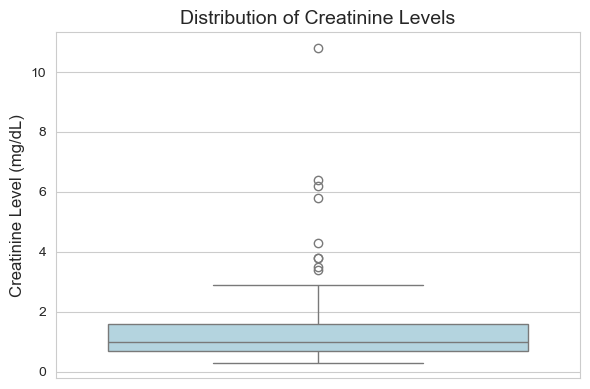

In [4]:
plt.figure(figsize=(6, 4))
sns.set_style("whitegrid")

ax = sns.boxplot(y=df['creatinine'].dropna(), color="lightblue")
plt.title('Distribution of Creatinine Levels', fontsize=14)
plt.ylabel('Creatinine Level (mg/dL)', fontsize=12)
plt.xticks([])  # Remove x-axis labels
plt.tight_layout()
plt.show()

# Save the figure
plt.savefig("C:\\Users\\ItamarMelnik\\Desktop\\ML in medicine\\creatinine_distribution.png", dpi=300)

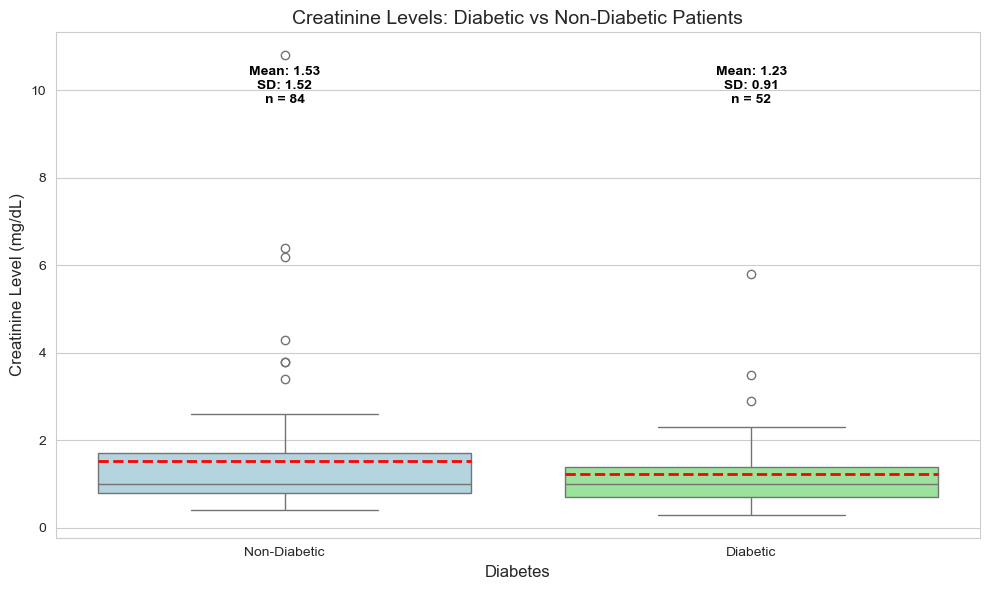

In [5]:
# Set visual style
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create boxplot comparing diabetic vs non-diabetic patients
ax = sns.boxplot(x='has_diabetes', y='creatinine', data=df, palette=["lightblue", "lightgreen"])

# Calculate statistics for each group
diabetic = df[df['has_diabetes'] == 1]['creatinine']
non_diabetic = df[df['has_diabetes'] == 0]['creatinine']


# Add mean lines to the boxplots
plt.hlines(y=non_diabetic.mean(), xmin=-0.4, xmax=0.4, color='red', linestyle='--', linewidth=2)
plt.hlines(y=diabetic.mean(), xmin=0.6, xmax=1.4, color='red', linestyle='--', linewidth=2)

# Add text for standard deviation and sample size
plt.text(0, max(df['creatinine'])*0.9, f"Mean: {non_diabetic.mean():.2f}\nSD: {non_diabetic.std():.2f}\nn = {len(non_diabetic)}", 
         horizontalalignment='center', size=10, color='black', weight='semibold')
plt.text(1, max(df['creatinine'])*0.9, f"Mean: {diabetic.mean():.2f}\nSD: {diabetic.std():.2f}\nn = {len(diabetic)}", 
         horizontalalignment='center', size=10, color='black', weight='semibold')

# Improve design and labels
plt.title('Creatinine Levels: Diabetic vs Non-Diabetic Patients', fontsize=14)
plt.xlabel('Diabetes', fontsize=12)
plt.ylabel('Creatinine Level (mg/dL)', fontsize=12)
plt.xticks([0, 1], ['Non-Diabetic', 'Diabetic'])

plt.tight_layout()
plt.show()

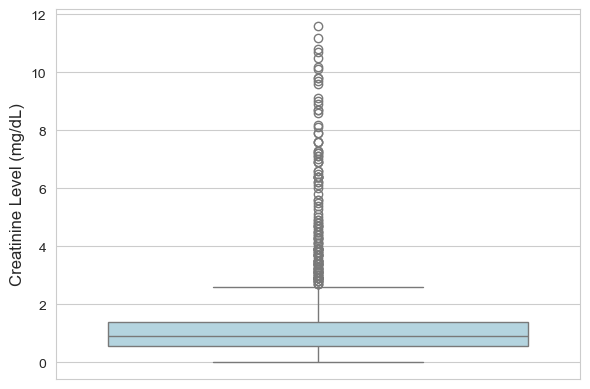

In [6]:
creatinine_valid = creatinine_valid[creatinine_valid['valuenum']<20]

plt.figure(figsize=(6, 4))
sns.set_style("whitegrid")

# Create boxplot
ax = sns.boxplot(y=creatinine_valid['valuenum'], color="lightblue")
plt.ylabel('Creatinine Level (mg/dL)', fontsize=12)
plt.xticks([])  # Remove x-axis labels
plt.tight_layout()
plt.show()

In [7]:
df['creatinine'].fillna(df['creatinine'].median(), inplace=True)

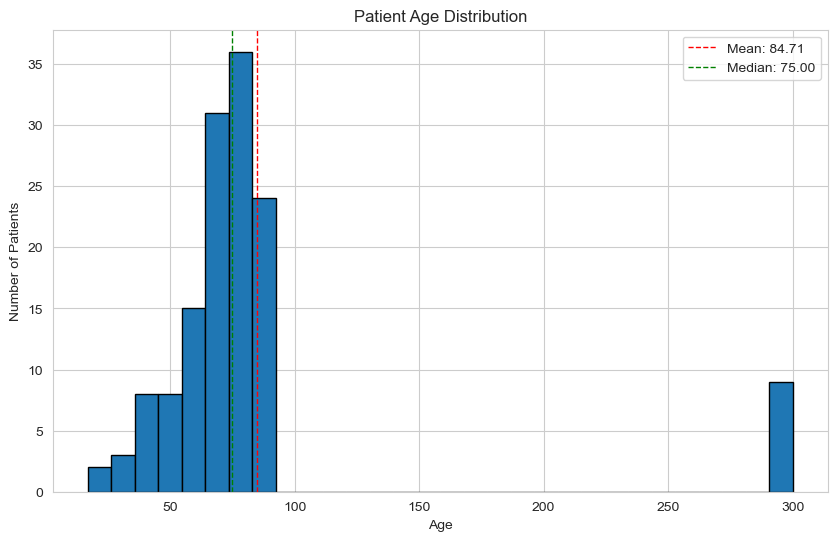

In [8]:
#Create age histogram
plt.figure(figsize=(10, 6))
plt.hist(df['age'].dropna(), bins=30, edgecolor='black')

# Add vertical lines for mean and median
plt.axvline(df['age'].mean(), color='red', linestyle='dashed', linewidth=1, label=f"Mean: {df['age'].mean():.2f}")
plt.axvline(df['age'].median(), color='green', linestyle='dashed', linewidth=1, label=f"Median: {df['age'].median():.2f}")

plt.title('Patient Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.legend()
plt.show()

In [9]:
df['age'] = np.where(df['age'] > 120, 90, df['age'])

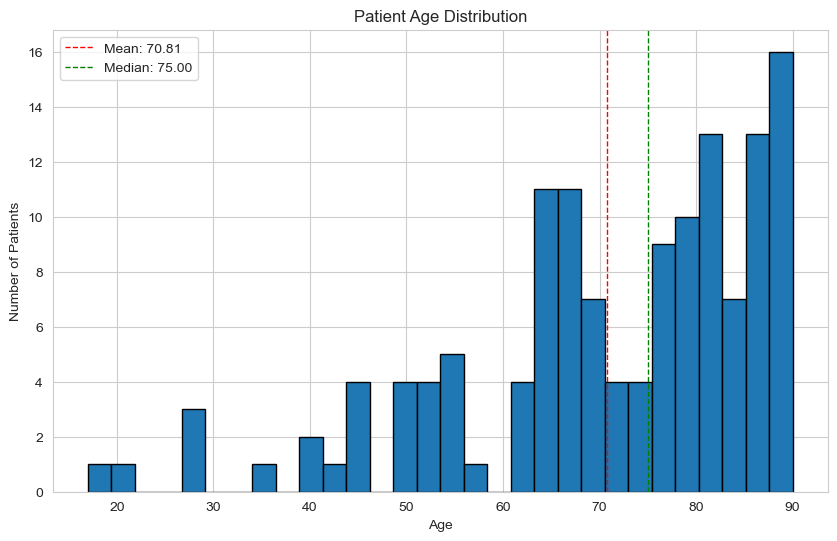

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(df['age'].dropna(), bins=30, edgecolor='black')

# Add vertical lines for mean and median
plt.axvline(df['age'].mean(), color='red', linestyle='dashed', linewidth=1, label=f"Mean: {df['age'].mean():.2f}")
plt.axvline(df['age'].median(), color='green', linestyle='dashed', linewidth=1, label=f"Median: {df['age'].median():.2f}")

plt.title('Patient Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.legend()
plt.show()

In [11]:
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 45, 60, 70, 80, 100], 
                         labels=['0-30', '31-45', '46-60', '61-70', '71-80', '81+'], 
                         right=True, include_lowest=True)

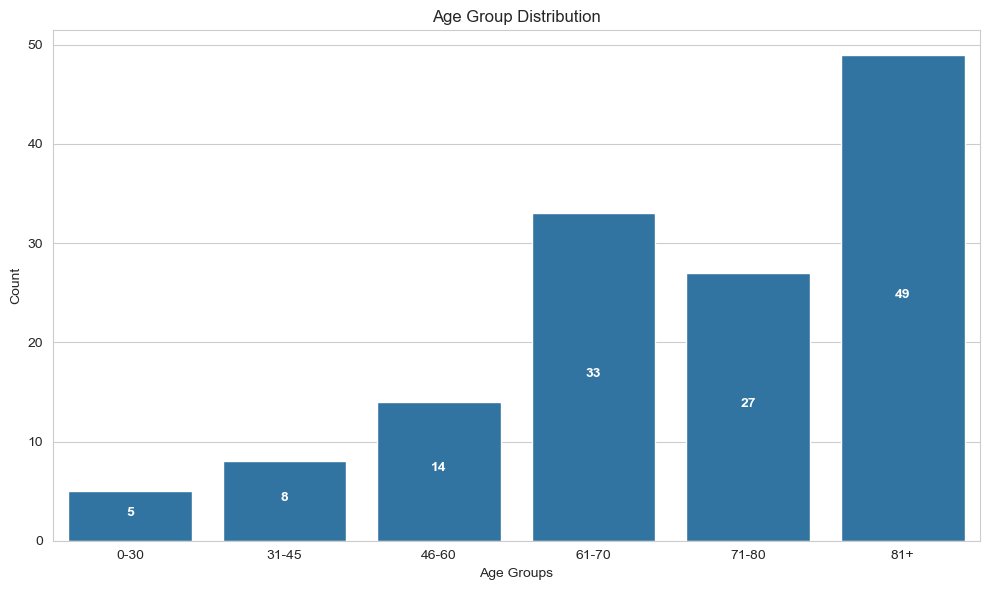

In [12]:
age_counts = df['age_group'].value_counts().sort_index()

# Create the plot
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=age_counts.index, y=age_counts.values)

# Add labels and title
plt.xlabel('Age Groups')
plt.ylabel('Count')
plt.title('Age Group Distribution')

for i, v in enumerate(age_counts.values):
    # Position the text in the middle of the bar
    plt.text(i, v/2, str(v), ha='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
df['ethnicity'].value_counts()

ethnicity
WHITE                                                       92
HISPANIC/LATINO - PUERTO RICAN                              15
UNKNOWN/NOT SPECIFIED                                       11
BLACK/AFRICAN AMERICAN                                       7
OTHER                                                        3
HISPANIC OR LATINO                                           3
ASIAN                                                        2
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE     2
UNABLE TO OBTAIN                                             1
Name: count, dtype: int64

In [14]:
# Define a mapping dictionary for ethnicities
ethnicity_mapping = {
    'WHITE': 'WHITE',
    'BLACK/AFRICAN AMERICAN': 'BLACK',
    'HISPANIC OR LATINO': 'HISPANIC',
    'HISPANIC/LATINO - PUERTO RICAN': 'HISPANIC',
    'ASIAN': 'OTHER',
    'OTHER': 'OTHER',
    'UNKNOWN/NOT SPECIFIED': 'OTHER',
    'UNABLE TO OBTAIN': 'OTHER',
    'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE': 'OTHER'
}
# Apply the mapping 
df['ethnicity'] = df['ethnicity'].map(ethnicity_mapping)

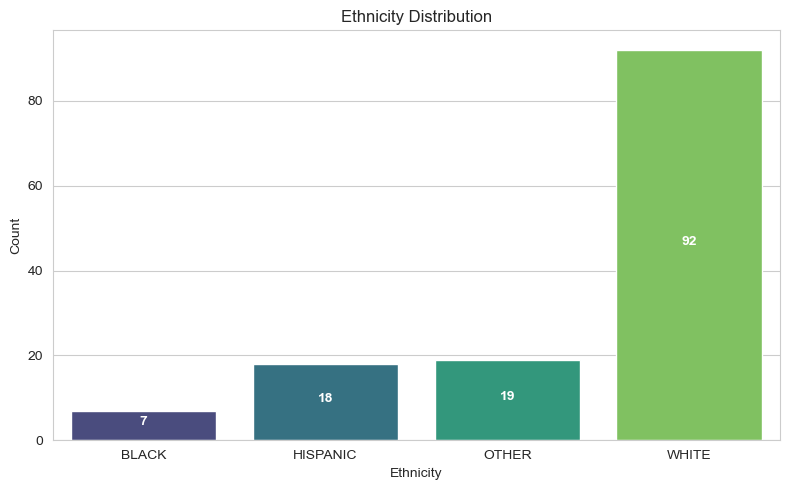

In [15]:
# Count the frequency of each ethnicity
ethnicity_counts = df['ethnicity'].value_counts().sort_values()
# Create the plot
plt.figure(figsize=(8, 5))
bars = sns.barplot(x=ethnicity_counts.index, y=ethnicity_counts.values, palette='viridis')

# Add labels and title
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Ethnicity Distribution')

# Add value labels inside each bar in white color
for i, v in enumerate(ethnicity_counts.values):
    plt.text(i, v/2, str(v), ha='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

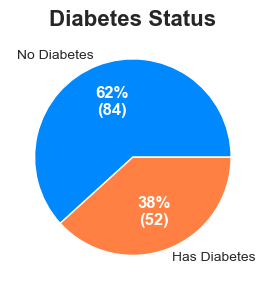

In [16]:
# עבור עמודת הסוכרת
diabetes_counts = df['has_diabetes'].value_counts()
diabetes_labels = ['No Diabetes', 'Has Diabetes'] if 0 in diabetes_counts.index else ['Has Diabetes', 'No Diabetes']
diabetes_sizes = diabetes_counts.values
diabetes_percentages = 100 * diabetes_sizes / diabetes_sizes.sum()

# יצירת גרף העוגה לסוכרת
plt.figure(figsize=(6, 3))
wedges, texts, autotexts = plt.pie(diabetes_sizes, labels=diabetes_labels, 
                                   autopct='', wedgeprops={'edgecolor': 'white'}, 
                                   colors=['#0088FE', '#FF8042'])

# הוספת המספרים והאחוזים בתוך הפלחים
for i, (pct, val) in enumerate(zip(diabetes_percentages, diabetes_sizes)):
    autotexts[i].set_text(f'{pct:.0f}%\n({val})')
    autotexts[i].set_color('white')
    autotexts[i].set_fontsize(12)
    autotexts[i].set_fontweight('bold')

plt.title('Diabetes Status', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('diabetes_pie.png')

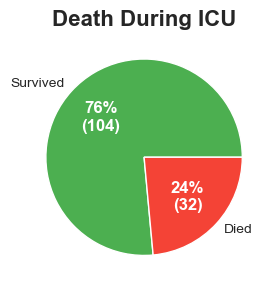

In [17]:
# עבור עמודת תמותה במהלך אשפוז
death_counts = df['death_during_icu'].value_counts()
death_labels = ['Survived', 'Died'] if 0 in death_counts.index else ['Died', 'Survived']
death_sizes = death_counts.values
death_percentages = 100 * death_sizes / death_sizes.sum()

# יצירת גרף העוגה לתמותה
plt.figure(figsize=(6, 3))
wedges, texts, autotexts = plt.pie(death_sizes, labels=death_labels, 
                                   autopct='', wedgeprops={'edgecolor': 'white'}, 
                                   colors=['#4CAF50', '#F44336'])

# הוספת המספרים והאחוזים בתוך הפלחים
for i, (pct, val) in enumerate(zip(death_percentages, death_sizes)):
    autotexts[i].set_text(f'{pct:.0f}%\n({val})')
    autotexts[i].set_color('white')
    autotexts[i].set_fontsize(12)
    autotexts[i].set_fontweight('bold')

plt.title('Death During ICU', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('death_during_icu_pie.png')

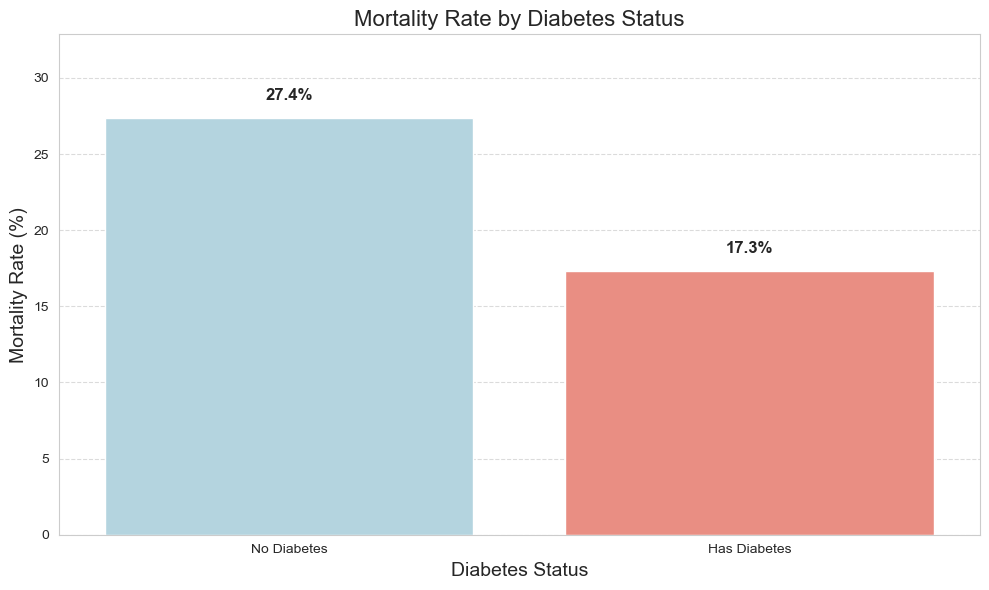

In [18]:
# Calculate mortality rates by diabetes status
mortality_by_diabetes = df.groupby('has_diabetes').agg(
    mortality_rate=('death_during_icu', lambda x: x.mean() * 100),
    count=('death_during_icu', 'count')
).reset_index()

# Replace numeric diabetes indicators with descriptive labels
mortality_by_diabetes['diabetes_status'] = mortality_by_diabetes['has_diabetes'].map(
    {0: 'No Diabetes', 1: 'Has Diabetes'}
)

# Create the plot
plt.figure(figsize=(10, 6))

# Use seaborn for a bar plot
ax = sns.barplot(
    x='diabetes_status', 
    y='mortality_rate', 
    data=mortality_by_diabetes,
    palette=['lightblue', 'salmon']
)

# Add percentage labels on top of bars
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    count = mortality_by_diabetes.iloc[i]['count']
    
    # Add percentage on top of bar
    ax.text(
        bar.get_x() + bar.get_width()/2.,
        height + 1,
        f'{height:.1f}%',
        ha='center', 
        va='bottom', 
        fontsize=12,
        fontweight='bold'
    )
    
# Titles and labels
plt.title('Mortality Rate by Diabetes Status', fontsize=16)
plt.xlabel('Diabetes Status', fontsize=14)
plt.ylabel('Mortality Rate (%)', fontsize=14)
plt.ylim(0, max(mortality_by_diabetes['mortality_rate']) * 1.2)  # Space for labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('mortality_by_diabetes.png')
plt.show()

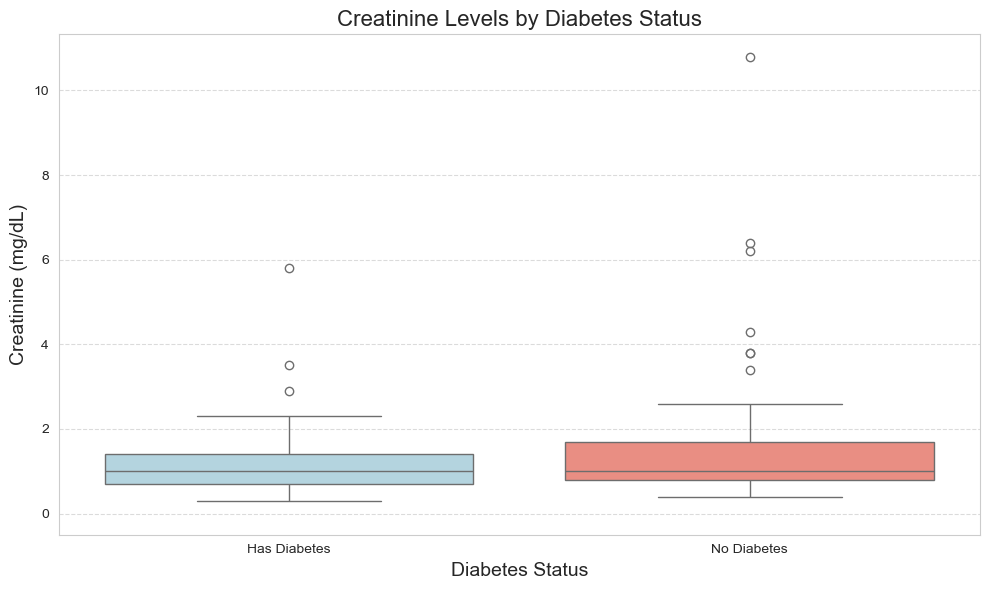

In [19]:

# Create a new column with descriptive labels for diabetes status
df['diabetes_status'] = df['has_diabetes'].map({0: 'No Diabetes', 1: 'Has Diabetes'})

# Create the box plot
plt.figure(figsize=(10, 6))

# Draw the box plot
ax = sns.boxplot(x='diabetes_status', y='creatinine', data=df, palette=['lightblue', 'salmon'])

# Add count and median labels
for i, (status, group) in enumerate(df.groupby('diabetes_status')):
    count = len(group)


# Set titles and labels
plt.title('Creatinine Levels by Diabetes Status', fontsize=16)
plt.xlabel('Diabetes Status', fontsize=14)
plt.ylabel('Creatinine (mg/dL)', fontsize=14)

# Adjust y-axis to show text below the plot
plt.ylim(bottom=-0.5)

# Add grid for easier reading
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('creatinine_by_diabetes_boxplot.png')
plt.show()

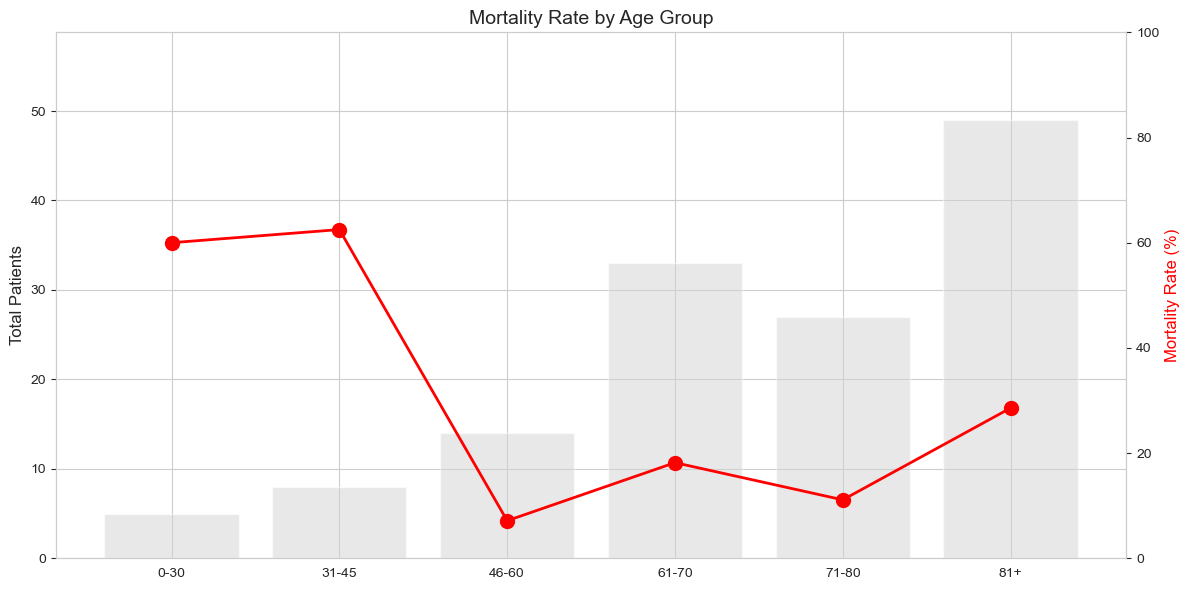

In [20]:
plt.figure(figsize=(12, 6))

# Calculate mortality rates by age group
age_mortality = pd.crosstab(df['age_group'], df['death_during_icu'])
age_mortality['mortality_rate'] = age_mortality[1] / (age_mortality[0] + age_mortality[1]) * 100
age_mortality['total_patients'] = age_mortality[0] + age_mortality[1]

# Plot mortality rate by age group as a line chart with bar count overlay
ax1 = plt.subplot(1, 1, 1)
ax1.bar(age_mortality.index, age_mortality['total_patients'], color='lightgray', alpha=0.5)
ax1.set_ylabel('Total Patients', fontsize=12)
ax1.set_ylim(0, age_mortality['total_patients'].max() * 1.2)

ax2 = ax1.twinx()
ax2.plot(age_mortality.index, age_mortality['mortality_rate'], marker='o', 
         color='red', linewidth=2, markersize=10)
ax2.set_ylabel('Mortality Rate (%)', fontsize=12, color='red')
ax2.set_ylim(0, 100)
ax2.grid(False)

plt.title('Mortality Rate by Age Group', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('age_group_mortality.png', dpi=300)
plt.show()

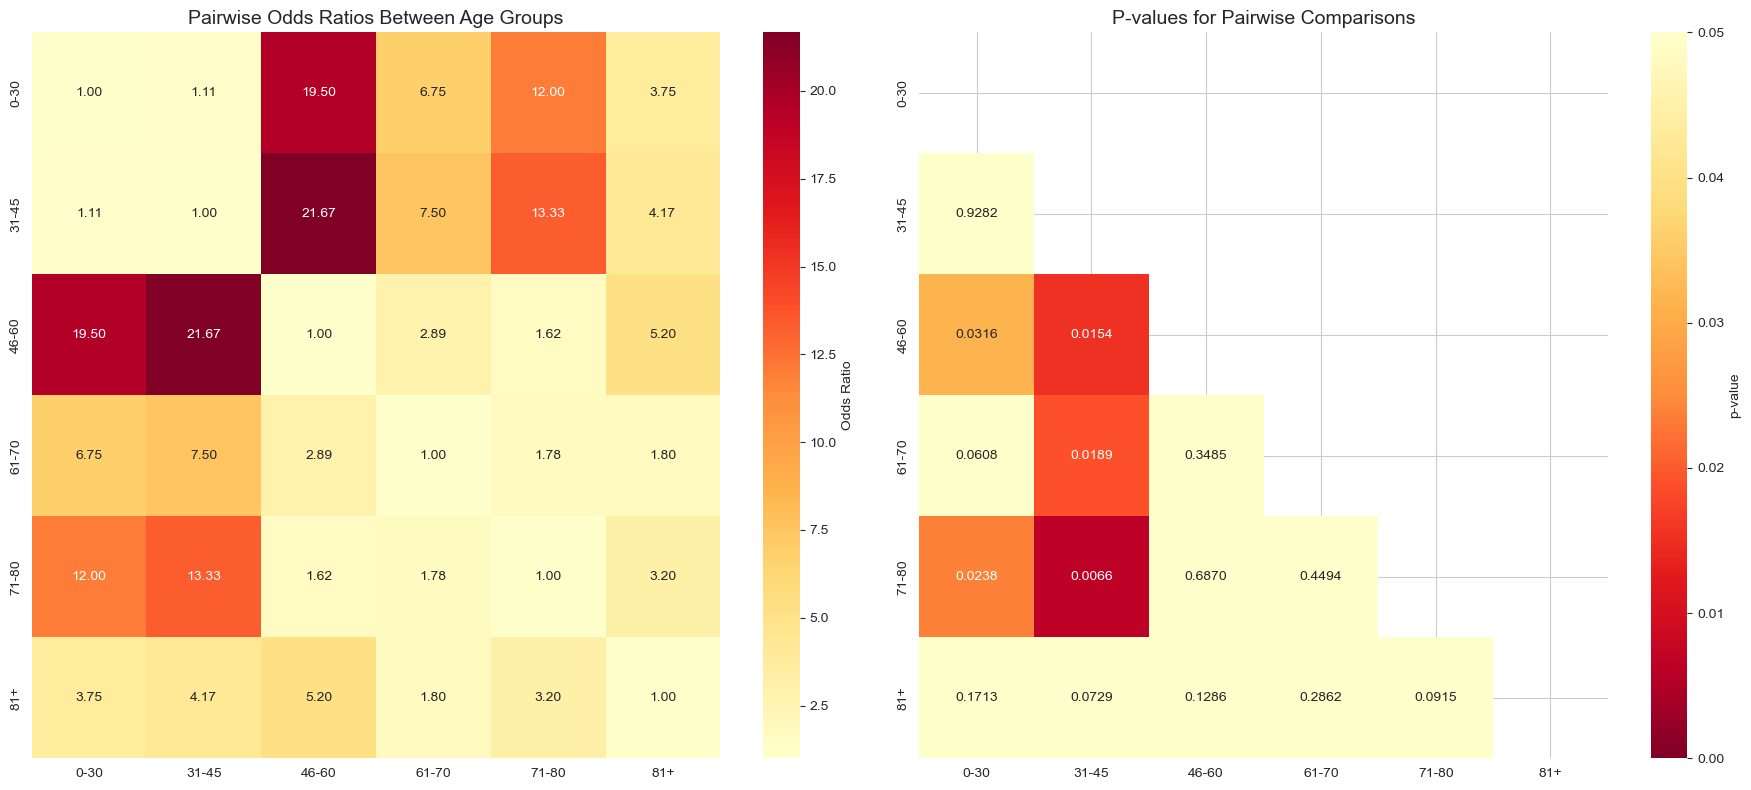

In [21]:
# Make a copy of the dataframe
df_logit = df.copy()

# Ensure death_during_icu is numeric
df_logit['death_during_icu'] = pd.to_numeric(df_logit['death_during_icu'])

# Get reference values for comparison
age_mortality = df_logit.groupby('age_group')['death_during_icu'].mean()
reference_age = age_mortality.idxmin()  # Use age group with lowest mortality as reference

# Perform direct pairwise comparisons without using formula API
def pairwise_analysis(df):
    # Sort age groups properly
    age_order = ['0-30', '31-45', '46-60', '61-70', '71-80', '81+']
    age_groups = [age for age in age_order]
    n_age_groups = len(age_groups)
    
    # Create empty matrices
    or_matrix = np.ones((n_age_groups, n_age_groups))
    pvalue_matrix = np.ones((n_age_groups, n_age_groups))
    significant_matrix = np.zeros((n_age_groups, n_age_groups), dtype=bool)
    
    # Create a results table for all comparisons with reference group
    odds_ratios_list = []
    
    # For each pair of age groups
    for i, age1 in enumerate(age_groups):
        for j, age2 in enumerate(age_groups):
            if i < j:  # Only compute once for each pair
                # Create temporary subset with just these two age groups
                subset = df[df['age_group'].isin([age1, age2])].copy()
                
                # Create dummy variable (use first age as reference)
                subset['age_dummy'] = (subset['age_group'] == age2).astype(int)
                
                # Fit logistic regression using direct API
                # Convert to numpy arrays to avoid dtype issues
                X_array = np.column_stack((np.ones(len(subset)), subset['age_dummy'].values))
                y_array = subset['death_during_icu'].values
                
                model = sm.Logit(y_array, X_array).fit(disp=False)
                
                # Store odds ratio and p-value
                or_value = np.exp(model.params[1])  # Index 1 is for age_dummy
                p_value = model.pvalues[1]
                
                # Determine which group has higher mortality
                mort1 = subset[subset['age_group'] == age1]['death_during_icu'].mean()
                mort2 = subset[subset['age_group'] == age2]['death_during_icu'].mean()
                
                # If age2 has lower mortality, invert the odds ratio
                if mort2 < mort1:
                    or_value = 1 / or_value
                    or_matrix[j, i] = or_value  # Put the higher value in the right place
                    or_matrix[i, j] = or_value  # Symmetric matrix for display
                else:
                    or_matrix[i, j] = or_value
                    or_matrix[j, i] = or_value  # Symmetric matrix for display
                
                pvalue_matrix[i, j] = p_value
                pvalue_matrix[j, i] = p_value  # Symmetric matrix for display
                
                significant_matrix[i, j] = p_value < 0.05
                significant_matrix[j, i] = p_value < 0.05  # Symmetric matrix
                
                # Add to odds ratios list if one of them is the reference age
                if age1 == reference_age:
                    odds_ratios_list.append({
                        'Age Group': age2,
                        'Odds Ratio': or_value,
                        'p-value': p_value,
                        'Significant': p_value < 0.05
                    })
                elif age2 == reference_age:
                    odds_ratios_list.append({
                        'Age Group': age1,
                        'Odds Ratio': 1/or_value,
                        'p-value': p_value,
                        'Significant': p_value < 0.05
                    })
    
    # Create odds ratio DataFrame for the reference comparison
    odds_ratios_df = pd.DataFrame(odds_ratios_list)
    if not odds_ratios_df.empty:
        odds_ratios_df = odds_ratios_df.sort_values('Odds Ratio', ascending=False)
        
        # Add the reference level (OR = 1.0)
        reference_row = pd.DataFrame([{
            'Age Group': reference_age,
            'Odds Ratio': 1.0,
            'p-value': np.nan,
            'Significant': False
        }])
        odds_ratios_df = pd.concat([odds_ratios_df, reference_row])
    
    return or_matrix, pvalue_matrix, significant_matrix, age_groups, odds_ratios_df

# Run the analysis
or_matrix, pvalue_matrix, significant_matrix, age_groups, odds_ratios = pairwise_analysis(df_logit)

# Create the heatmap visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Odds ratio heatmap
sns.heatmap(or_matrix, annot=True, fmt=".2f", cmap="YlOrRd", 
            xticklabels=age_groups, yticklabels=age_groups, 
            cbar_kws={"label": "Odds Ratio"}, ax=axes[0])

axes[0].set_title("Pairwise Odds Ratios Between Age Groups", fontsize=14)

# P-value heatmap
mask = np.triu(np.ones_like(pvalue_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(pvalue_matrix, annot=True, fmt=".4f", cmap="YlOrRd_r", mask=mask,
            xticklabels=age_groups, yticklabels=age_groups, 
            cbar_kws={"label": "p-value"}, vmin=0, vmax=0.05, ax=axes[1])


axes[1].set_title("P-values for Pairwise Comparisons", fontsize=14)

plt.tight_layout()
plt.savefig('age_group_or_heatmap.png')
plt.show()

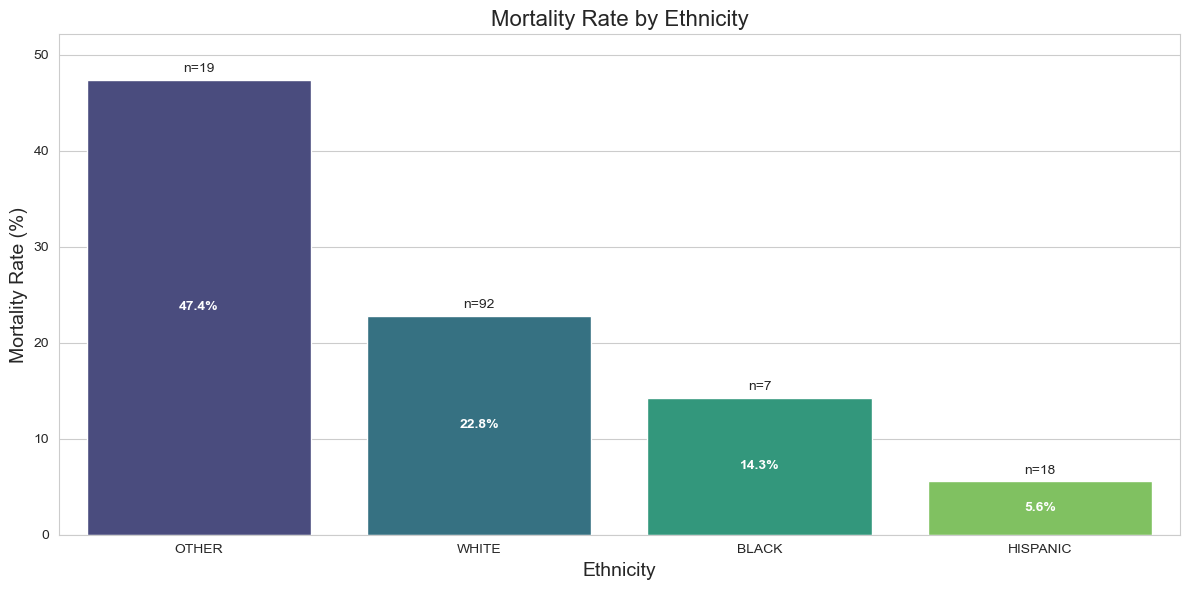

In [22]:
plt.figure(figsize=(12, 6))

# Calculate mortality rates by ethnicity
ethnicity_mortality = df.groupby('ethnicity')['death_during_icu'].mean() * 100
ethnicity_counts = df.groupby('ethnicity').size()

# Create DataFrame for plotting
ethnicity_df = pd.DataFrame({
    'ethnicity': ethnicity_mortality.index,
    'mortality_rate': ethnicity_mortality.values,
    'count': ethnicity_counts.values
}).sort_values('mortality_rate', ascending=False)

# Create bar plot
ax = sns.barplot(x='ethnicity', y='mortality_rate', data=ethnicity_df, palette='viridis')

# Add percentage labels inside bars
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height/2,
            f'{height:.1f}%',
            ha="center", va="center", color="white", fontweight="bold")

# Add count labels above bars
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.5,
            f'n={ethnicity_df.iloc[i]["count"]}',
            ha="center", va="bottom")

# Set titles and labels
plt.title('Mortality Rate by Ethnicity', fontsize=16)
plt.xlabel('Ethnicity', fontsize=14)
plt.ylabel('Mortality Rate (%)', fontsize=14)
plt.ylim(0, max(ethnicity_mortality) * 1.1)  # Add some space for count labels

# Ensure no overlap
plt.tight_layout()

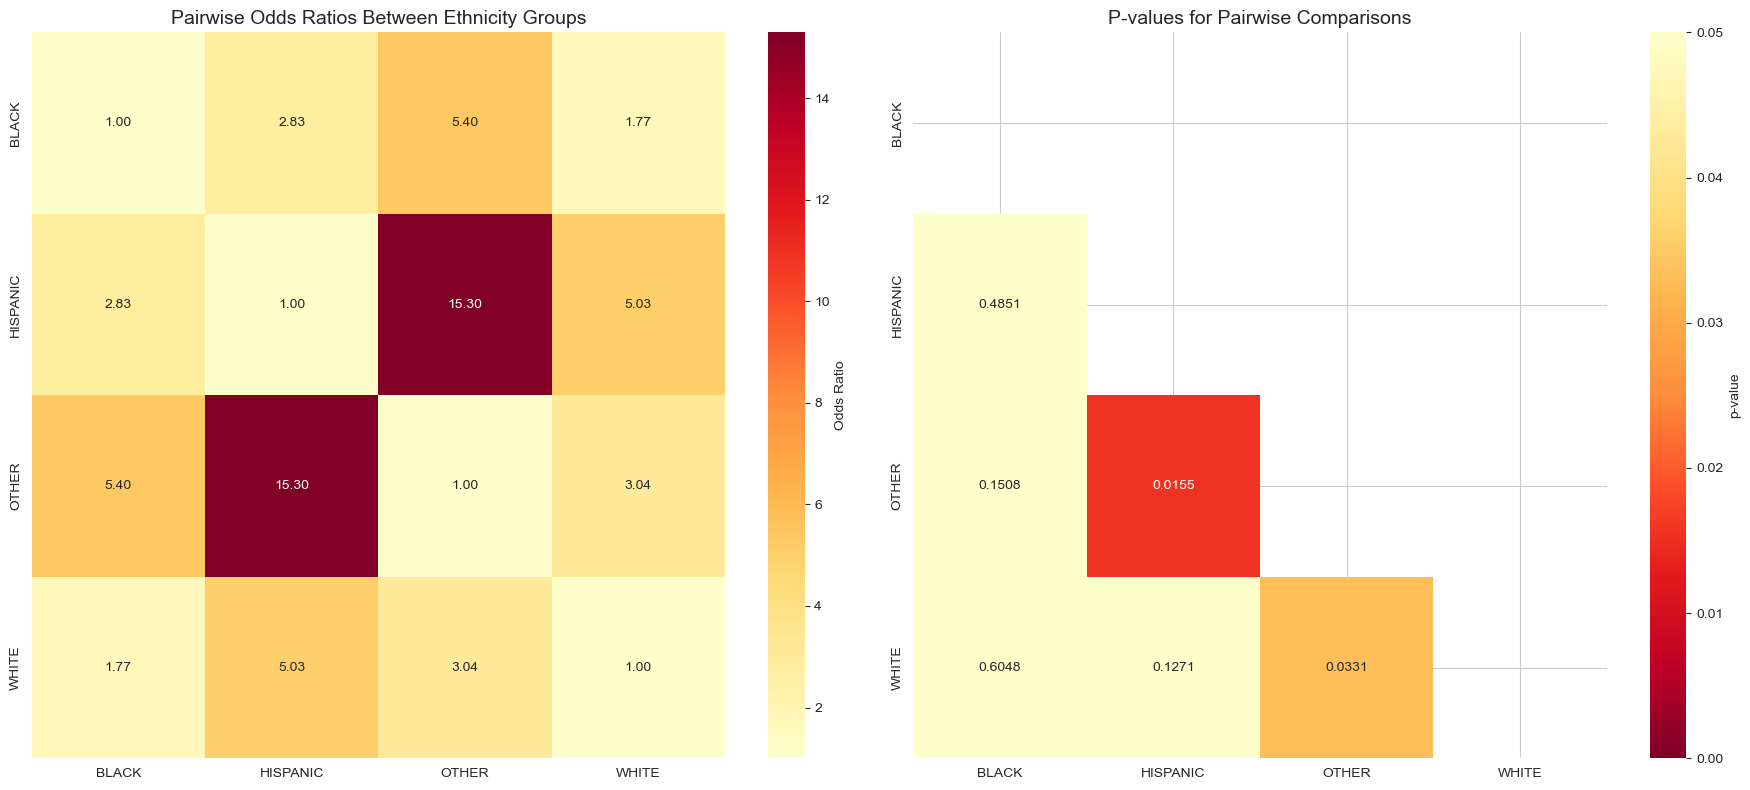

In [23]:
# Make a copy of the dataframe
df_logit = df.copy()

# Get reference values for comparison
ethnicity_mortality = df_logit.groupby('ethnicity')['death_during_icu'].mean()
reference_ethnicity = ethnicity_mortality.idxmin()  # Use ethnicity with lowest mortality as reference

# Perform direct pairwise comparisons
def pairwise_analysis(df):
    # Get all ethnicities
    ethnicities = sorted(df['ethnicity'].unique())
    n_ethnicities = len(ethnicities)
    
    # Create empty matrices
    or_matrix = np.ones((n_ethnicities, n_ethnicities))
    pvalue_matrix = np.ones((n_ethnicities, n_ethnicities))
    significant_matrix = np.zeros((n_ethnicities, n_ethnicities), dtype=bool)
    
    # For each pair of ethnicities
    for i, eth1 in enumerate(ethnicities):
        for j, eth2 in enumerate(ethnicities):
            if i < j:  # Only compute once for each pair
                # Create temporary subset with just these two ethnicities
                subset = df[df['ethnicity'].isin([eth1, eth2])].copy()
                
                # Create dummy variable (use first ethnicity as reference)
                subset['eth_dummy'] = (subset['ethnicity'] == eth2).astype(int)
                
                # Convert to numpy arrays to avoid dtype issues
                X_array = np.column_stack((np.ones(len(subset)), subset['eth_dummy'].values))
                y_array = subset['death_during_icu'].values
                
                model = sm.Logit(y_array, X_array).fit(disp=False)
                
                # Store odds ratio and p-value
                or_value = np.exp(model.params[1])  # Index 1 is for eth_dummy
                p_value = model.pvalues[1]
                
                # Determine which group has higher mortality
                mort1 = subset[subset['ethnicity'] == eth1]['death_during_icu'].mean()
                mort2 = subset[subset['ethnicity'] == eth2]['death_during_icu'].mean()
                
                # If eth2 has lower mortality, invert the odds ratio
                if mort2 < mort1:
                    or_value = 1 / or_value
                    or_matrix[j, i] = or_value
                    or_matrix[i, j] = or_value  # Symmetric matrix for display
                else:
                    or_matrix[i, j] = or_value
                    or_matrix[j, i] = or_value  # Symmetric matrix for display
                
                pvalue_matrix[i, j] = p_value
                pvalue_matrix[j, i] = p_value  # Symmetric matrix for display
                
                significant_matrix[i, j] = p_value < 0.05
                significant_matrix[j, i] = p_value < 0.05  # Symmetric matrix
    
    return or_matrix, pvalue_matrix, significant_matrix, ethnicities

# Run the analysis
or_matrix, pvalue_matrix, significant_matrix, ethnicities = pairwise_analysis(df_logit)

# Create the heatmap visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Odds ratio heatmap
sns.heatmap(or_matrix, annot=True, fmt=".2f", cmap="YlOrRd", 
            xticklabels=ethnicities, yticklabels=ethnicities, 
            cbar_kws={"label": "Odds Ratio"}, ax=axes[0])

axes[0].set_title("Pairwise Odds Ratios Between Ethnicity Groups", fontsize=14)

# P-value heatmap
mask = np.triu(np.ones_like(pvalue_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(pvalue_matrix, annot=True, fmt=".4f", cmap="YlOrRd_r", mask=mask,
            xticklabels=ethnicities, yticklabels=ethnicities, 
            cbar_kws={"label": "p-value"}, vmin=0, vmax=0.05, ax=axes[1])


axes[1].set_title("P-values for Pairwise Comparisons", fontsize=14)

plt.tight_layout()
plt.savefig('ethnicity_or_heatmap.png')
plt.show()

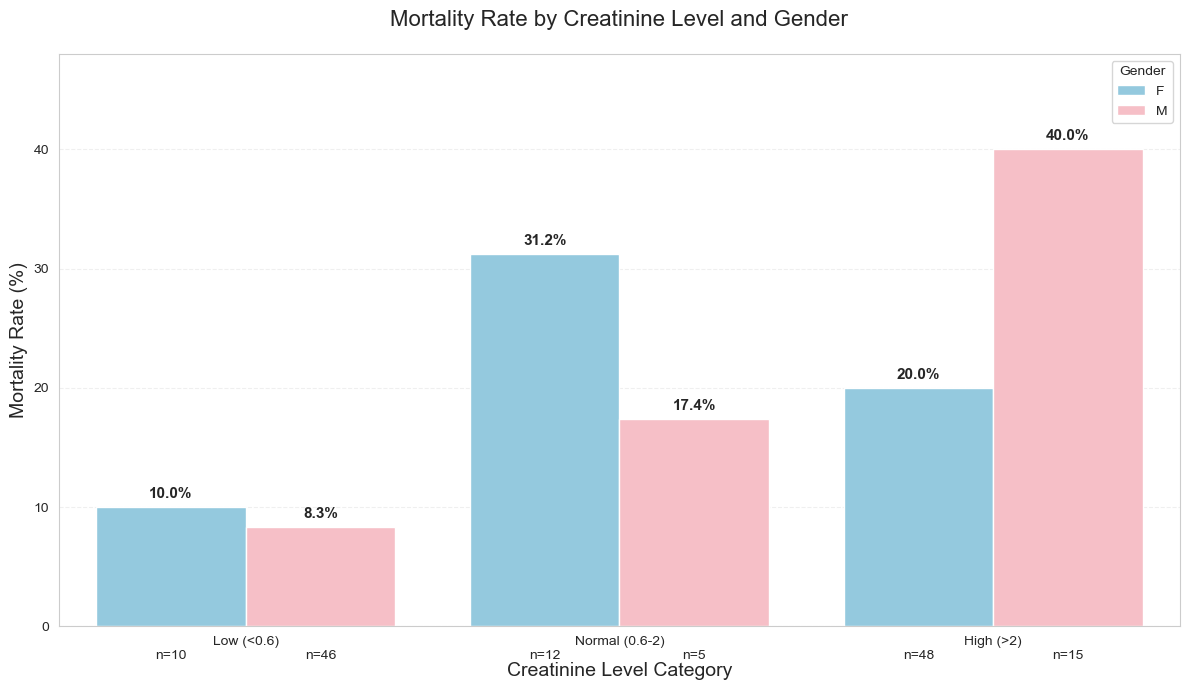

In [32]:
# Create bins for creatinine levels with improved ranges
df['creatinine_category'] = pd.cut(
    df['creatinine'], 
    bins=[0, 0.6, 2, np.inf],
    labels=['Low (<0.6)', 'Normal (0.6-2)', 'High (>2)']
)

# Calculate mortality rate by creatinine category and gender
mortality_by_creatinine_gender = df.groupby(['creatinine_category', 'gender'])['death_during_icu'].agg(['mean', 'count'])
mortality_by_creatinine_gender['mortality_rate'] = mortality_by_creatinine_gender['mean'] * 100
mortality_by_creatinine_gender.reset_index(inplace=True)

# Create the plot with improved formatting
plt.figure(figsize=(12, 7))

# Use seaborn for a bar plot with gender differentiation
ax = sns.barplot(
    x='creatinine_category', 
    y='mortality_rate', 
    hue='gender', 
    data=mortality_by_creatinine_gender,
    palette=['skyblue', 'lightpink']  # Lighter colors for better visibility
)

# Add percentage labels on top of bars with better positioning
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    if not np.isnan(height) and height > 0:  # Only if there's a valid value and it's greater than 0
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            height + 0.5,  # Position just above the bar
            f'{height:.1f}%',
            ha='center', 
            va='bottom', 
            fontsize=11,
            fontweight='bold'
        )

# Add sample size at bottom of chart with better visibility
for i, row in mortality_by_creatinine_gender.iterrows():
    count = row['count']
    bar = ax.patches[i]
    
    # Add count below x-axis with increased spacing
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        -2,  # More space below
        f'n={count}',
        ha='center',
        va='top',
        fontsize=10
    )

# Improve titles and labels
plt.title('Mortality Rate by Creatinine Level and Gender', fontsize=16, pad=20)
plt.xlabel('Creatinine Level Category', fontsize=14, labelpad=10)
plt.ylabel('Mortality Rate (%)', fontsize=14)
plt.legend(title='Gender', loc='upper right')

# Increase y-axis limit to make room for percentage labels
plt.ylim(0, max(mortality_by_creatinine_gender['mortality_rate'].fillna(0)) * 1.2)  

# Add more space at bottom for n-values
plt.subplots_adjust(bottom=0.15)

# Add grid for easier reading of values
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('mortality_by_creatinine_gender_improved.png', dpi=300, bbox_inches='tight')
plt.show()

Analysis of Creatinine Levels and Mortality by Gender (Mann-Whitney U Test)

Male Patients - Creatinine Summary Statistics:
              mean  median       std  count
Survived  1.286207     1.0  0.975390     58
Died      2.560000     1.4  2.722341     15

Mann-Whitney U Test (non-parametric):
U statistic: 261.0
p-value: 0.0176
Significant difference: Yes (p < 0.05)

Female Patients - Creatinine Summary Statistics:
              mean  median       std  count
Survived  1.282609     1.0  1.031569     46
Died      1.147059     1.0  0.498896     17

Mann-Whitney U Test (non-parametric):
U statistic: 374.0
p-value: 0.7977
Significant difference: No (p ≥ 0.05)


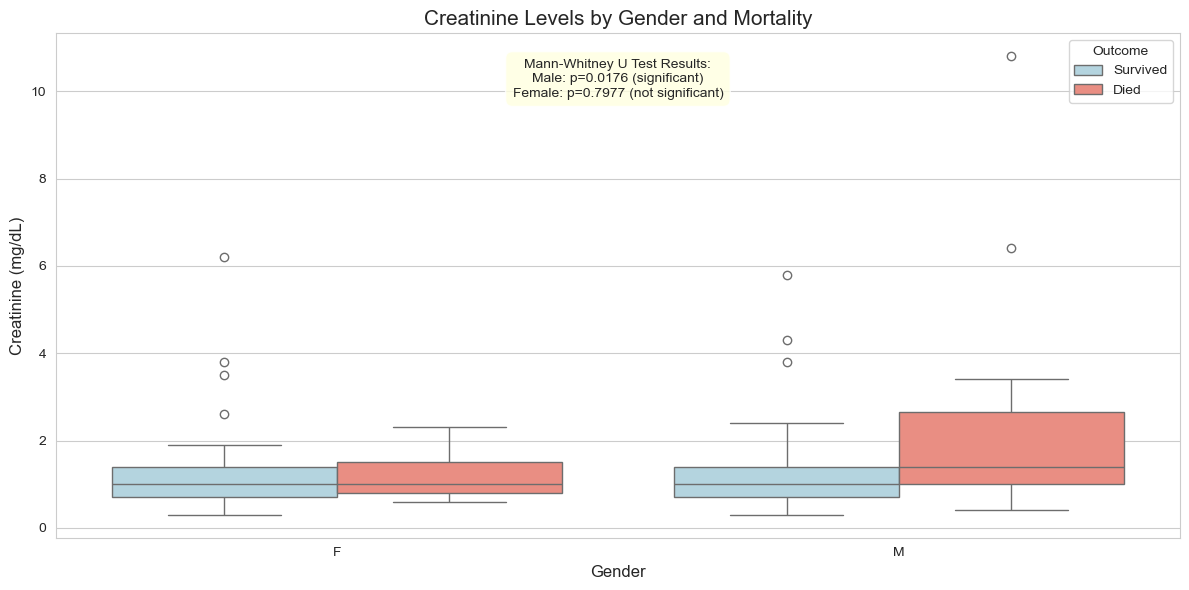

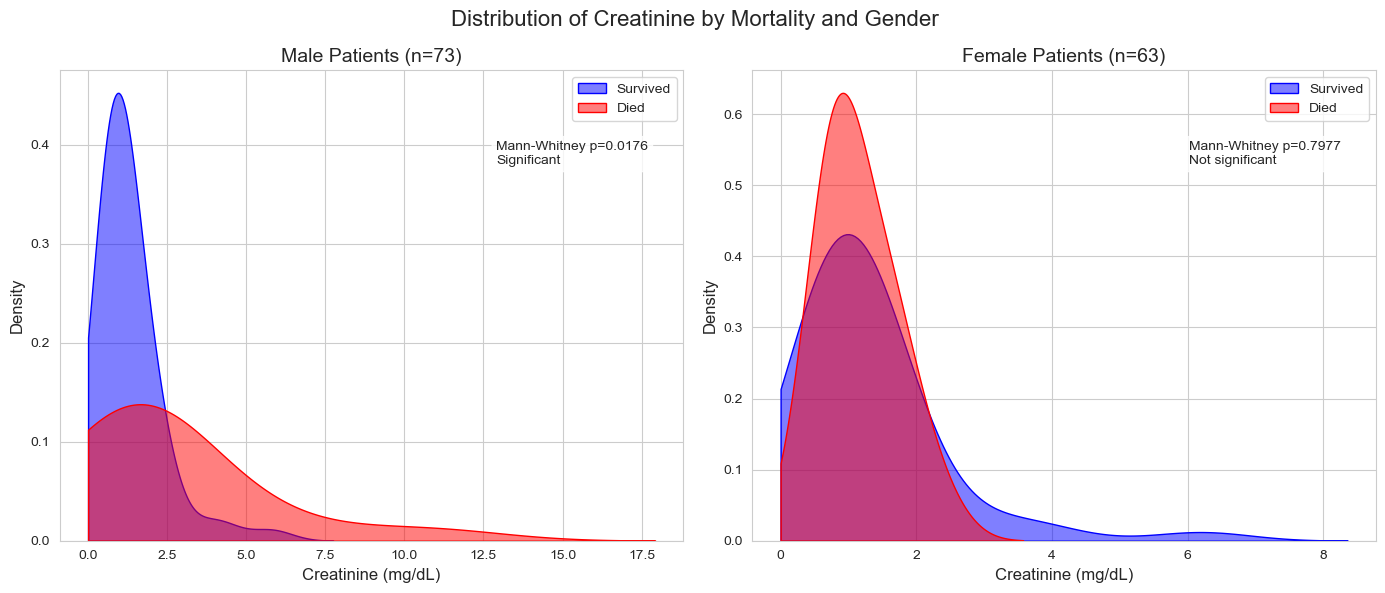

In [33]:
# Create separate dataframes for male and female patients
male_df = df[df['gender'] == 'M'].copy()
female_df = df[df['gender'] == 'F'].copy()

# Function to perform Mann-Whitney U test
def analyze_creatinine_mortality(gender_df, gender_name):
    # Summary statistics
    creatinine_by_outcome = gender_df.groupby('death_during_icu')['creatinine'].agg(['mean', 'median', 'std', 'count'])
    creatinine_by_outcome.index = ['Survived', 'Died']
    print(f"\n{gender_name} Patients - Creatinine Summary Statistics:")
    print(creatinine_by_outcome)
    
    # Extract creatinine values for each outcome group
    survived = gender_df[gender_df['death_during_icu'] == 0]['creatinine']
    died = gender_df[gender_df['death_during_icu'] == 1]['creatinine']
    
    
    # Perform Mann-Whitney U test (non-parametric)
    u_stat, p_value = mannwhitneyu(survived, died)
    print(f"\nMann-Whitney U Test (non-parametric):")
    print(f"U statistic: {u_stat}")
    print(f"p-value: {p_value:.4f}")
    print(f"Significant difference: {'Yes (p < 0.05)' if p_value < 0.05 else 'No (p ≥ 0.05)'}")
    
    return survived, died, u_stat, p_value

# Analyze each gender
print("="*50)
print("Analysis of Creatinine Levels and Mortality by Gender (Mann-Whitney U Test)")
print("="*50)

male_survived, male_died, male_u, male_p = analyze_creatinine_mortality(male_df, "Male")
female_survived, female_died, female_u, female_p = analyze_creatinine_mortality(female_df, "Female")

# Create boxplot visualization
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='gender', y='creatinine', hue='death_during_icu', 
                 data=df, palette=['lightblue', 'salmon'])

# Set the labels and title
plt.title('Creatinine Levels by Gender and Mortality', fontsize=15)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Creatinine (mg/dL)', fontsize=12)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['Survived', 'Died'], title='Outcome')

# Add Mann-Whitney test results to the plot
if male_p is not None and female_p is not None:
    annotation_text = (
        f"Mann-Whitney U Test Results:\n"
        f"Male: p={male_p:.4f} {'(significant)' if male_p < 0.05 else '(not significant)'}\n"
        f"Female: p={female_p:.4f} {'(significant)' if female_p < 0.05 else '(not significant)'}"
    )
    plt.annotate(
        annotation_text,
        xy=(0.5, 0.95),
        xycoords='axes fraction',
        ha='center',
        va='top',
        bbox=dict(boxstyle="round,pad=0.5", fc='lightyellow', alpha=0.8)
    )

plt.tight_layout()
plt.savefig('creatinine_by_gender_and_mortality_boxplot.png')
plt.show()

# Create density plots with constraints to keep values positive
plt.figure(figsize=(14, 6))

# Male patients
plt.subplot(1, 2, 1)
if male_survived is not None and male_died is not None:
    # Use clip parameter to ensure density is plotted only for positive values
    sns.kdeplot(male_survived, fill=True, color='blue', alpha=0.5, label='Survived', 
                clip=(0, None), bw_adjust=1.5)
    sns.kdeplot(male_died, fill=True, color='red', alpha=0.5, label='Died', 
                clip=(0, None), bw_adjust=1.5)
    plt.title(f'Male Patients (n={len(male_df)})', fontsize=14)
    plt.xlabel('Creatinine (mg/dL)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    
    # Add Mann-Whitney p-value to the plot
    if male_p is not None:
        plt.annotate(
            f"Mann-Whitney p={male_p:.4f}\n{'Significant' if male_p < 0.05 else 'Not significant'}",
            xy=(0.7, 0.8),
            xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.8)
        )

# Female patients
plt.subplot(1, 2, 2)
if female_survived is not None and female_died is not None:
    # Use clip parameter to ensure density is plotted only for positive values
    sns.kdeplot(female_survived, fill=True, color='blue', alpha=0.5, label='Survived', 
                clip=(0, None), bw_adjust=1.5)
    sns.kdeplot(female_died, fill=True, color='red', alpha=0.5, label='Died', 
                clip=(0, None), bw_adjust=1.5)
    plt.title(f'Female Patients (n={len(female_df)})', fontsize=14)
    plt.xlabel('Creatinine (mg/dL)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    
    # Add Mann-Whitney p-value to the plot
    if female_p is not None:
        plt.annotate(
            f"Mann-Whitney p={female_p:.4f}\n{'Significant' if female_p < 0.05 else 'Not significant'}",
            xy=(0.7, 0.8),
            xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.8)
        )

plt.suptitle('Distribution of Creatinine by Mortality and Gender', fontsize=16)
plt.tight_layout()
plt.savefig('creatinine_density_by_gender_and_mortality.png')
plt.show()